In [12]:
import pandas as pd
from MultilevelRF import *
from read_multilevel import *
from MEM_regression import *
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, kruskal
import statannot
from paths import DATA_DIR, RESULTS_DIR_MEM, FEATURES_DIR, SUBJECTS_PATH, SUBJECTS_PATH, cohort, cohorts
from utils_psychological import create_classes, mapping_col_to_fun
from itertools import combinations
from utils_MEM import args

print("Psychosocial Features analysis on ", cohort, "cohort")


Psychosocial Features analysis on  chronic cohort


In [13]:
data = load_data_psycho(performance_path=RESULTS_DIR_MEM, area="mp", path_data_medication=SUBJECTS_PATH)
data_physio = load_data_y_Z_pain(**cohorts)
#set the index as index without removing
data_physio = helpers.select_single_area(data_physio , area=args[ 'area' ])
data_physio.set_index('id', inplace=True, drop=True)
data_physio_avg = data_physio.groupby('id').mean()
#merge data_psy with data_physio based on index
data = data.merge(data_physio_avg[ "NRS" ] , left_index=True , right_index=True)
data["NRS_now-SB"]=data["NRS_now"]-data["average_subj_bias"]
data["NRS_avg4wk-SB"]=data["NRS_avg4wk"]-data["average_subj_bias"]
data["NRS_acute-SB"]=data["NRS"]-data["average_subj_bias"]
col_target="average_subj_bias" ##    TARGET:     NRS_acute-SB (PHI), average_subj_bias (TIP), NRS (NRS)
data = data[ data[col_target].notna() ]
norm=False
if norm:
    data[ col_target ] = (data[ col_target ] - data[ col_target ].min()) / (
            data[ col_target ].max() - data[ col_target ].min())

## MAIN psychosocial and clinical

HADS_D
low
(61,)
high
(19,)
(80,)
HADS_A
low
(55,)
high
(24,)
(79,)
PCS
low
(69,)
high
(11,)
(80,)
QST_HPT_mp
hyper
(41,)
hypo
(27,)
(68,)
sick_leave
high sick
(16,)
no sick
(54,)
(70,)
health
bad
(9,)
good
(61,)
(70,)
HADS_D normal
HADS_A normal
PCS normal


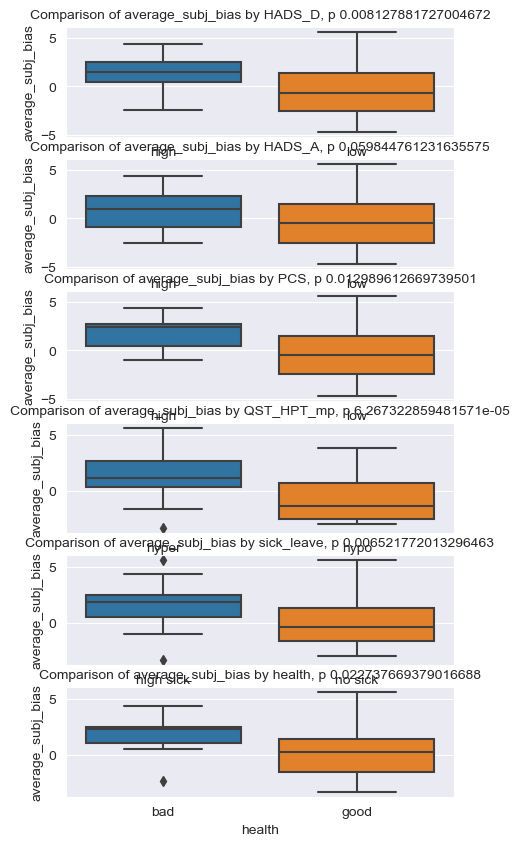

In [14]:
# Define the desired significance level
cols=["HADS_D", "HADS_A", "PCS", "QST_HPT_mp", "sick_leave", "health"]
for col in cols:
    print(col)
    data.loc[:, col]=data.apply(mapping_col_to_fun(col),axis=1, col=col)
    data_tmp=data[col].dropna()
    for el in set(data_tmp):
        print(el)
        print(data_tmp[data_tmp==el].shape)
    print(data_tmp.shape)
alpha = 0.05
# Define a list to store significant results
significant_results = []
fig, axs=plt.subplots(len(cols), 1, figsize=(5,10))
for i,col in enumerate(cols):
    # Remove NaN values from the column
    data_tmp= data[~data[col].isnull()]

    # Check if the column has only two unique values
    if len(data_tmp[col].unique()) == 2:
        # Sort the unique values in the column
        unique_values = sorted(data_tmp[col].unique())

        # Create the distributions based on average_subj_bias
        group1 = data_tmp.loc[data_tmp[col] == unique_values[0], col_target]
        group2 = data_tmp.loc[data_tmp[col] == unique_values[1], col_target]

        if len(group1)>=3 and len(group2)>=3:
            # Check if the distributions are normal with Shapiro test
            shapiro_group1 = shapiro(group1)
            shapiro_group2 = shapiro(group2)

            if shapiro_group1.pvalue > alpha and shapiro_group2.pvalue > alpha:
                # Perform independent t-test
                ttest_result = ttest_ind(group1, group2,alternative="greater")
                test_type = 't-test_ind'
                test_statistic = ttest_result.statistic
                test_pvalue = ttest_result.pvalue
                print(col, "normal")
            else:
                # Perform Mann-Whitney U test
                mannwhitneyu_result = mannwhitneyu(group1, group2,alternative="greater")
                test_type = 'Mann-Whitney-gt'
                test_statistic = mannwhitneyu_result.statistic
                test_pvalue = mannwhitneyu_result.pvalue
             
        else:
            # Perform Mann-Whitney U test
            mannwhitneyu_result = mannwhitneyu(group1, group2,alternative="greater")
            test_type = 'Mann-Whitney-gt'
            test_statistic = mannwhitneyu_result.statistic
            test_pvalue = mannwhitneyu_result.pvalue
            

        # Add the result to the list of significant results if it's significant
        if test_pvalue < alpha:
            significant_results.append((col, unique_values[0], unique_values[1], test_type, test_statistic, test_pvalue))

        data_to_plot = [group1, group2]
        sns.boxplot(x=col, y=col_target, data=data_tmp, order=unique_values, ax=axs[i])
        axs[i].set_xticklabels(unique_values)
        axs[i].set_xlabel(col)
        axs[i].set_ylabel(col_target)
        axs[i].set_title(f'Comparison of {col_target} by {col}, p {test_pvalue}')
    else:
        # Create the boxplot
        plt.figure()
        sns.boxplot(x=col, y=col_target, data=data_tmp, ax=axs[i])
        axs[i].set_xlabel(col)
        axs[i].set_ylabel(col_target)
        axs[i].set_title(f'Comparison of {col_target} by {col}')
plt.savefig(RESULTS_DIR_MEM+"important_psychosocial_{}.pdf".format(col_target))
plt.show()

## NRS

NRS_avg4wk
low
(43,)
high
(37,)
(80,)
NRS_max4wk
low
(16,)
high
(64,)
(80,)
NRS_now
low
(48,)
high
(32,)
(80,)
NRS_avg4wk normal


<Figure size 640x480 with 0 Axes>

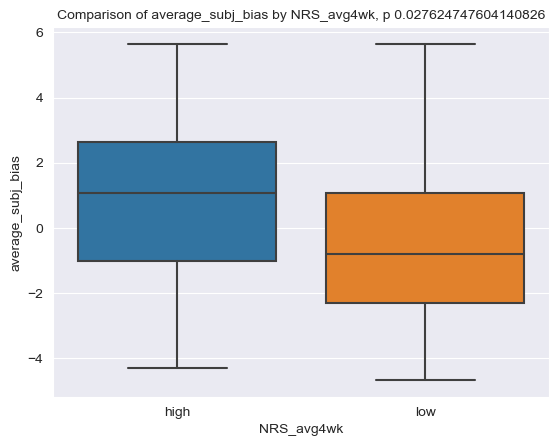

NRS_max4wk normal


<Figure size 640x480 with 0 Axes>

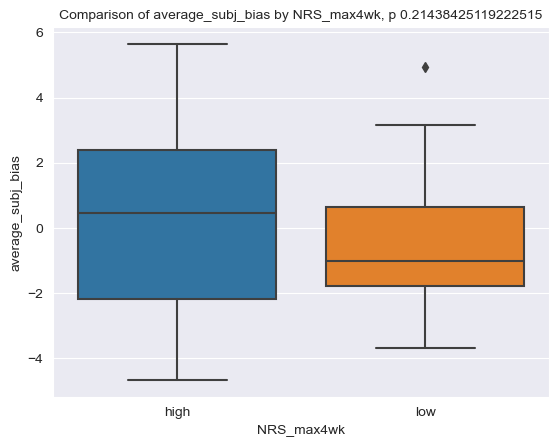

NRS_now normal


<Figure size 640x480 with 0 Axes>

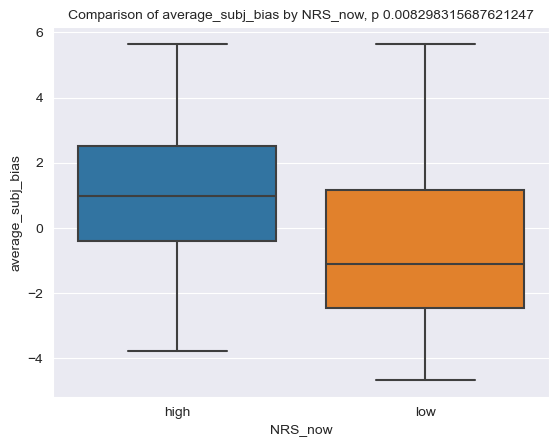

In [15]:
cols=["NRS_avg4wk","NRS_max4wk","NRS_now"]
for col in cols:
    print(col)
    data.loc[:, col]=data.apply(mapping_col_to_fun(col),axis=1, col=col)
    data_tmp=data[col].dropna()
    for el in set(data_tmp):
        print(el)
        print(data_tmp[data_tmp==el].shape)
    print(data_tmp.shape)
significant_results = []
for col in cols:
    # Remove NaN values from the column
    data_tmp= data[~data[col].isnull()]

    # Check if the column has only two unique values
    if len(data_tmp[col].unique()) == 2:
        # Sort the unique values in the column
        unique_values = sorted(data_tmp[col].unique())

        # Create the distributions based on average_subj_bias
        group1 = data_tmp.loc[data_tmp[col] == unique_values[0], col_target]
        group2 = data_tmp.loc[data_tmp[col] == unique_values[1], col_target]

        if len(group1)>=3 and len(group2)>=3:
            # Check if the distributions are normal with Shapiro test
            shapiro_group1 = shapiro(group1)
            shapiro_group2 = shapiro(group2)

            if shapiro_group1.pvalue > alpha and shapiro_group2.pvalue > alpha:
                # Perform independent t-test
                ttest_result = ttest_ind(group1, group2, alternative="greater")
                test_type = 't-test_ind'
                test_statistic = ttest_result.statistic
                test_pvalue = ttest_result.pvalue
                print(col, "normal")
            else:
                # Perform Mann-Whitney U test
                mannwhitneyu_result = mannwhitneyu(group1, group2, alternative="greater")
                test_type = 'Mann-Whitney-gt'
                test_statistic = mannwhitneyu_result.statistic
                test_pvalue = mannwhitneyu_result.pvalue

        else:
            # Perform Mann-Whitney U test
            mannwhitneyu_result = mannwhitneyu(group1, group2, alternative="greater")
            test_type = 'Mann-Whitney-gt'
            test_statistic = mannwhitneyu_result.statistic
            test_pvalue = mannwhitneyu_result.pvalue


        # Add the result to the list of significant results if it's significant
        if test_pvalue < alpha:
            significant_results.append((col, unique_values[0], unique_values[1], test_type, test_statistic, test_pvalue))

        # Create the boxplot
        plt.figure()
        fig, ax = plt.subplots()
        data_to_plot = [group1, group2]
        ax = sns.boxplot(x=col, y=col_target, data=data_tmp, order=unique_values)
        ax.set_xticklabels(unique_values)
        ax.set_xlabel(col)
        ax.set_ylabel(col_target)
        ax.set_title(f'Comparison of {col_target} by {col}, p {test_pvalue}')
        plt.savefig(RESULTS_DIR_MEM+"chornic_psycho_{}_{}.pdf".format(col, col_target))
        plt.show()
    else:
        # Create the boxplot
        plt.figure()
        fig, ax = plt.subplots()
        ax = sns.boxplot(x=col, y=col_target, data=data_tmp)
        ax.set_xlabel(col)
        ax.set_ylabel(col_target)
        ax.set_title(f'Comparison of {col_target} by {col}')
        plt.savefig(RESULTS_DIR_MEM+"chornic_psycho_{}_{}.pdf".format(col, col_target))
        plt.show()

## MAIA

life_qual normal


<Figure size 640x480 with 0 Axes>

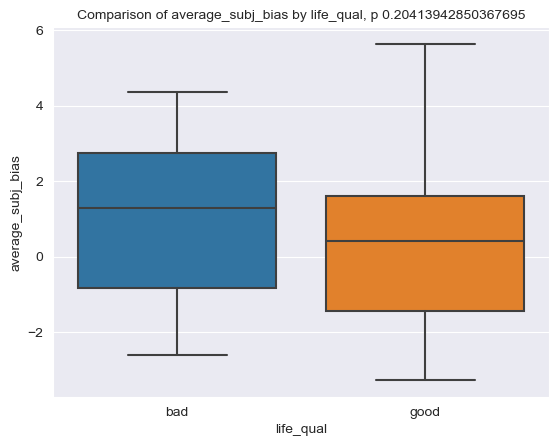

MAIA_Noticing normal


<Figure size 640x480 with 0 Axes>

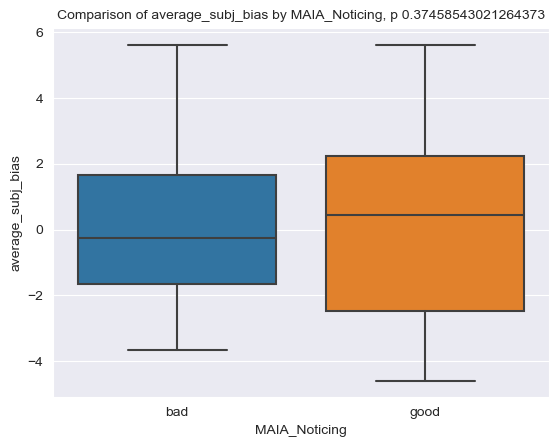

MAIA_NotDistracting normal


<Figure size 640x480 with 0 Axes>

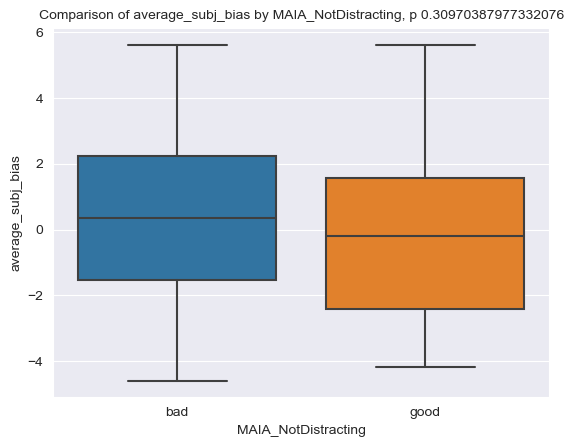

MAIA_NotWorrying normal


<Figure size 640x480 with 0 Axes>

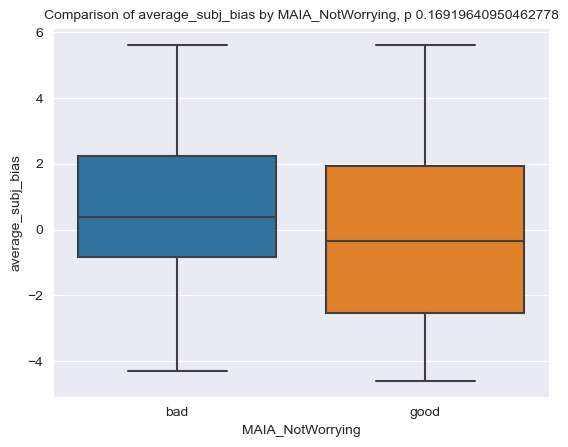

MAIA_AttentionRegulation normal


<Figure size 640x480 with 0 Axes>

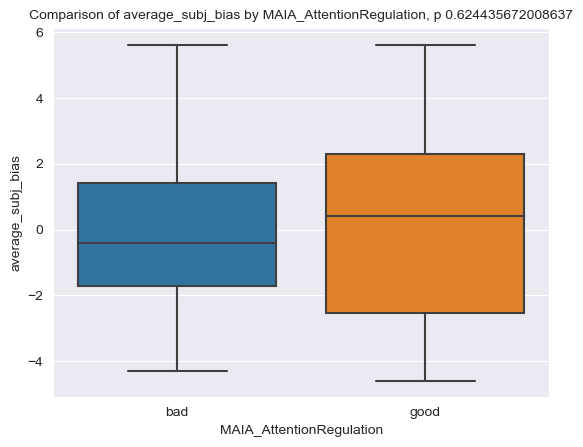

MAIA_EmotionalAwareness normal


<Figure size 640x480 with 0 Axes>

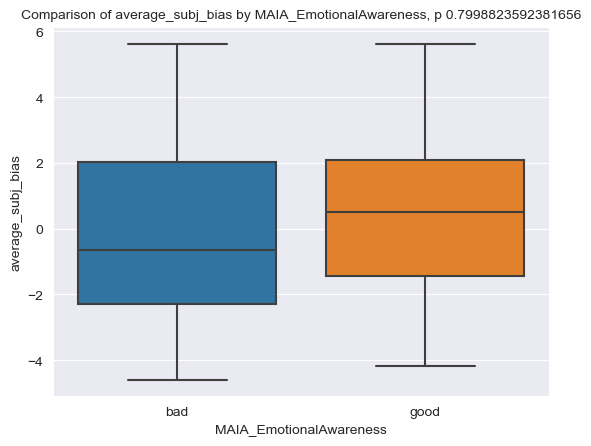

MAIA_SelfRegulation normal


<Figure size 640x480 with 0 Axes>

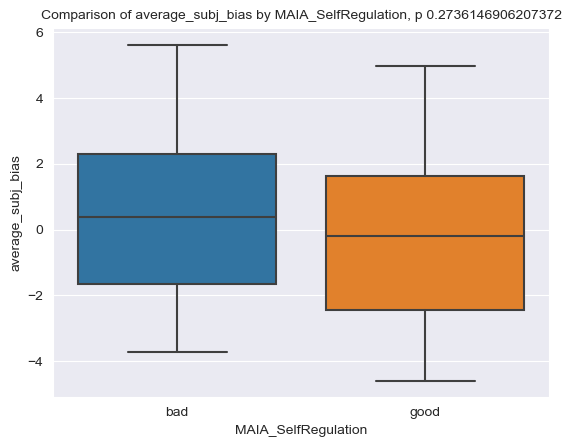

MAIA_BodyListening normal


<Figure size 640x480 with 0 Axes>

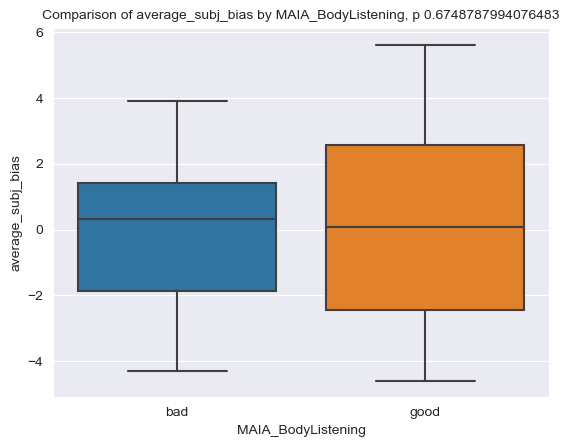

MAIA_Trusting normal


<Figure size 640x480 with 0 Axes>

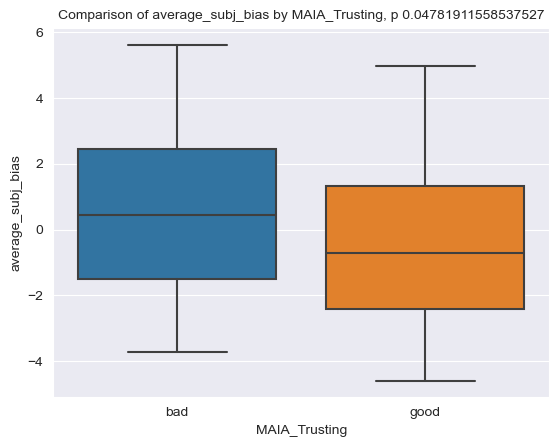

In [5]:
cols=["life_qual", "MAIA_Noticing","MAIA_NotDistracting" ,  "MAIA_NotWorrying", "MAIA_AttentionRegulation", "MAIA_EmotionalAwareness",
 "MAIA_SelfRegulation", "MAIA_BodyListening","MAIA_Trusting"]
for col in cols:
    data.loc[:, col]=data.apply(mapping_col_to_fun(col),axis=1, col=col)
    # Remove NaN values from the column
    data_tmp= data[~data[col].isnull()]

    # Check if the column has only two unique values
    if len(data_tmp[col].unique()) == 2:
        # Sort the unique values in the column
        unique_values = sorted(data_tmp[col].unique())

        # Create the distributions based on average_subj_bias
        group1 = data_tmp.loc[data_tmp[col] == unique_values[0], col_target]
        group2 = data_tmp.loc[data_tmp[col] == unique_values[1], col_target]

        if len(group1)>=3 and len(group2)>=3:
            # Check if the distributions are normal with Shapiro test
            shapiro_group1 = shapiro(group1)
            shapiro_group2 = shapiro(group2)

            if shapiro_group1.pvalue > alpha and shapiro_group2.pvalue > alpha:
                # Perform independent t-test
                ttest_result = ttest_ind(group1, group2, alternative="greater")
                test_type = 't-test_ind'
                test_statistic = ttest_result.statistic
                test_pvalue = ttest_result.pvalue
                print(col, "normal")
            else:
                # Perform Mann-Whitney U test
                mannwhitneyu_result = mannwhitneyu(group1, group2, alternative="greater")
                test_type = 'Mann-Whitney-gt'
                test_statistic = mannwhitneyu_result.statistic
                test_pvalue = mannwhitneyu_result.pvalue
             
        else:
            # Perform Mann-Whitney U test
            mannwhitneyu_result = mannwhitneyu(group1, group2, alternative="greater")
            test_type = 'Mann-Whitney-gt'
            test_statistic = mannwhitneyu_result.statistic
            test_pvalue = mannwhitneyu_result.pvalue

        # Add the result to the list of significant results if it's significant
        if test_pvalue < alpha:
            significant_results.append((col, unique_values[0], unique_values[1], test_type, test_statistic, test_pvalue))
        # Create the boxplot
        plt.figure()
        fig, ax = plt.subplots()
        data_to_plot = [group1, group2]
        ax = sns.boxplot(x=col, y=col_target, data=data_tmp, order=unique_values)
        ax.set_xticklabels(unique_values)
        ax.set_xlabel(col)
        ax.set_ylabel(col_target)
        ax.set_title(f'Comparison of {col_target} by {col}, p {test_pvalue}')
        plt.show()
    else:
        # Create the boxplot
        plt.figure()
        fig, ax = plt.subplots()
        ax = sns.boxplot(x=col, y=col_target, data=data_tmp)
        ax.set_xlabel(col)
        ax.set_ylabel(col_target)
        ax.set_title(f'Comparison of {col_target} by {col}')
        plt.show()

## MEDS, GENDER, PSEQ, BMI, SLEEP

Gender normal


<Figure size 640x480 with 0 Axes>

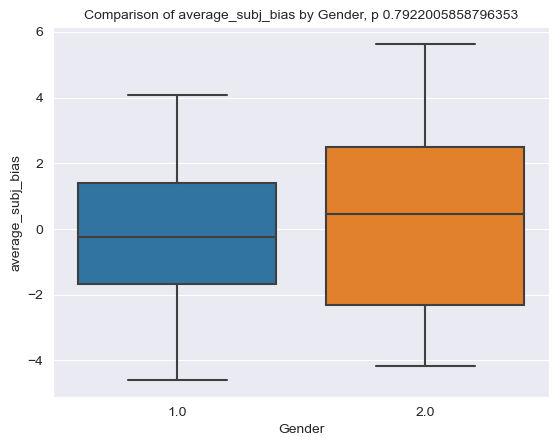

BMI normal


<Figure size 640x480 with 0 Axes>

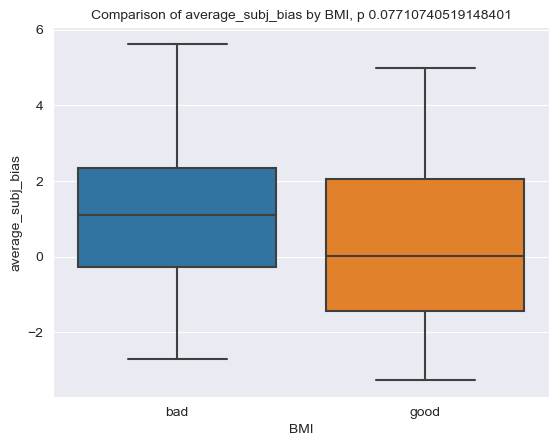

sleep normal


<Figure size 640x480 with 0 Axes>

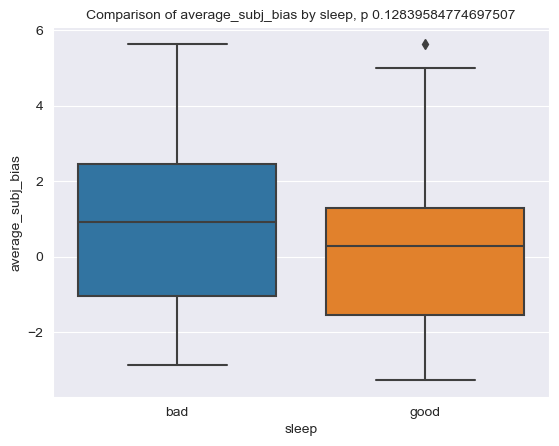

PSEQ normal


<Figure size 640x480 with 0 Axes>

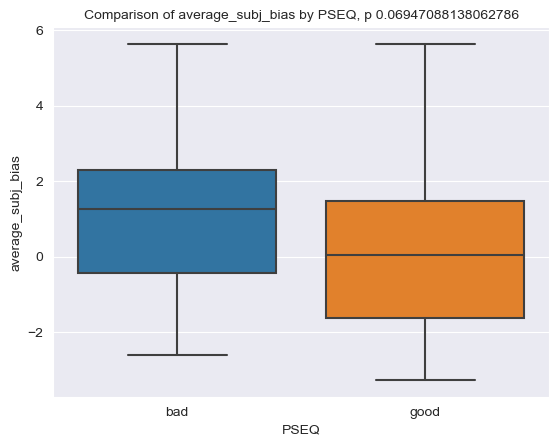

painkillers normal


<Figure size 640x480 with 0 Axes>

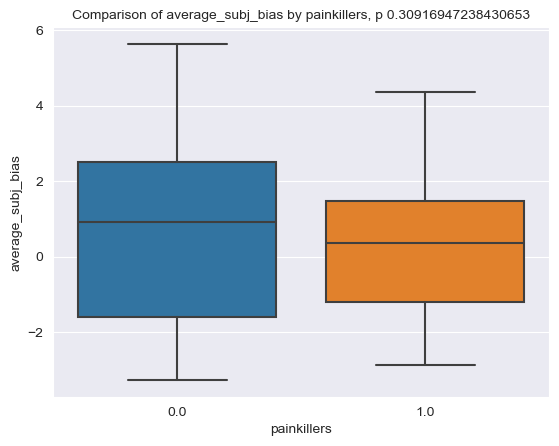

other_meds normal


<Figure size 640x480 with 0 Axes>

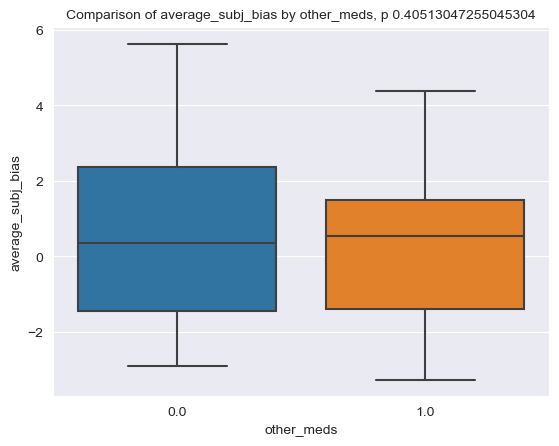

In [6]:
cols=['PSEQ', 'BMI', 'sleep']
for col in cols:
    data.loc[:, col]=data.apply(mapping_col_to_fun(col),axis=1, col=col)
cols=['Gender', 'BMI', 'sleep','PSEQ', 'painkillers','other_meds']
for col in cols:
    # Remove NaN values from the column
    data_tmp= data[~data[col].isnull()]

    # Check if the column has only two unique values
    if len(data_tmp[col].unique()) == 2:
        # Sort the unique values in the column
        unique_values = sorted(data_tmp[col].unique())

        # Create the distributions based on average_subj_bias
        group1 = data_tmp.loc[data_tmp[col] == unique_values[0], col_target]
        group2 = data_tmp.loc[data_tmp[col] == unique_values[1], col_target]

        if len(group1)>=3 and len(group2)>=3:
            # Check if the distributions are normal with Shapiro test
            shapiro_group1 = shapiro(group1)
            shapiro_group2 = shapiro(group2)

            if shapiro_group1.pvalue > alpha and shapiro_group2.pvalue > alpha:
                # Perform independent t-test
                ttest_result = ttest_ind(group1, group2, alternative="greater")
                test_type = 't-test_ind'
                test_statistic = ttest_result.statistic
                test_pvalue = ttest_result.pvalue
                print(col, "normal")
            else:
                # Perform Mann-Whitney U test
                mannwhitneyu_result = mannwhitneyu(group1, group2, alternative="greater")
                test_type = 'Mann-Whitney-gt'
                test_statistic = mannwhitneyu_result.statistic
                test_pvalue = mannwhitneyu_result.pvalue
             
        else:
            # Perform Mann-Whitney U test
            mannwhitneyu_result = mannwhitneyu(group1, group2, alternative="greater")
            test_type = 'Mann-Whitney-gt'
            test_statistic = mannwhitneyu_result.statistic
            test_pvalue = mannwhitneyu_result.pvalue


        # Add the result to the list of significant results if it's significant
        if test_pvalue < alpha:
            significant_results.append((col, unique_values[0], unique_values[1], test_type, test_statistic, test_pvalue))

        # Create the boxplot
        plt.figure()
        fig, ax = plt.subplots()
        data_to_plot = [group1, group2]
        ax = sns.boxplot(x=col, y=col_target, data=data_tmp, order=unique_values)
        ax.set_xticklabels(unique_values)
        ax.set_xlabel(col)
        ax.set_ylabel(col_target)
        ax.set_title(f'Comparison of {col_target} by {col}, p {test_pvalue}')
        plt.savefig(RESULTS_DIR_MEM+"{}_{}.pdf".format(col, col_target))
        plt.show()
    else:
        # Create the boxplot
        plt.figure()
        fig, ax = plt.subplots()
        ax = sns.boxplot(x=col, y=col_target, data=data_tmp)
        ax.set_xlabel(col)
        ax.set_ylabel(col_target)
        ax.set_title(f'Comparison of {col_target} by {col}')
        plt.savefig(RESULTS_DIR_MEM+"{}_{}.pdf".format(col, col_target))
        plt.show()

## others

['0', '1', '2']
KruskalResult(statistic=0.9533724797766183, pvalue=0.6208372927156474)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 640x480 with 0 Axes>

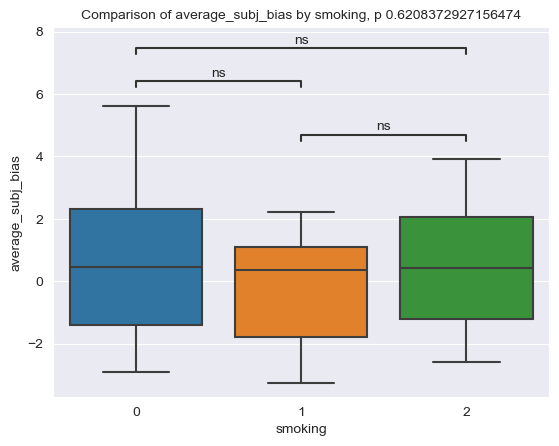


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['0', '1', '2']
KruskalResult(statistic=1.7255059770386936, pvalue=0.4219987240540294)


<Figure size 640x480 with 0 Axes>

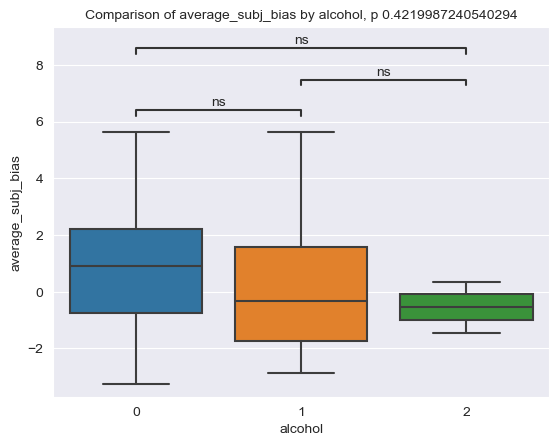

['1', '2', '3', '4', '5', '6']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KruskalResult(statistic=7.267042253521112, pvalue=0.20152547323385506)


<Figure size 640x480 with 0 Axes>

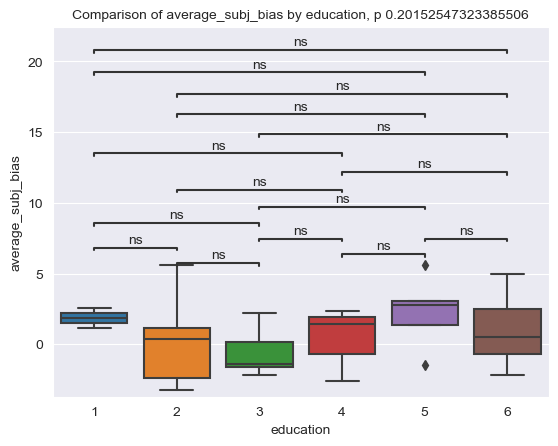

['1', '2', '3', '4']
KruskalResult(statistic=3.4287093404416, pvalue=0.3301266644113546)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 640x480 with 0 Axes>

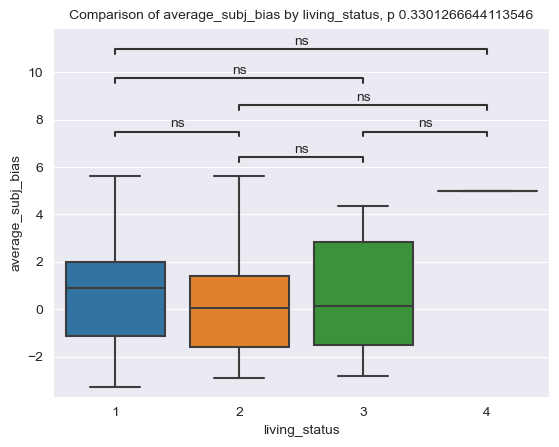

In [7]:
cols=['smoking','alcohol', 'education', 'living_status']
for col in cols:
    # Remove NaN values from the column
    data_tmp= data[~data[col].isnull()]
    data_tmp[col]=data_tmp[col].astype(int).astype(str)
    # Sort the unique values in the column
    unique_values = sorted(data_tmp[col].unique())
    print(unique_values)
    kruskal_results=kruskal(*[data_tmp[data_tmp[col]==i][col_target] for i in unique_values])
    print(kruskal_results)
    # Create the boxplot
    plt.figure()
    fig, ax = plt.subplots()
    ax = sns.boxplot(x=col, y=col_target, data=data_tmp, order=unique_values)
    ax.set_xticklabels(unique_values)
    ax.set_xlabel(col)
    ax.set_ylabel(col_target)
    ax.set_title(f'Comparison of {col_target} by {col}, p {kruskal_results.pvalue}')
    combs = combinations(unique_values, 2)

    # create a set to store the non-repeated pairs of tuples
    pairs = set()

    # convert each combination to a tuple and add it to the set
    for comb in combs:
        pairs.add(tuple(sorted(comb)))
    # Add the significance to the plot using statannot
    stat_result = statannot.add_stat_annotation(ax, data=data_tmp,x=col,y=col_target,box_pairs=tuple(pairs),
                                      test="Kruskal", text_format='star', loc='inside',
                                      verbose=0, comparisons_correction=None)
    plt.show()

## Cohort

In [8]:
col="cohort"
data=helpers.undummy(data, col, drop_flag=False)

# Remove NaN values from the column
data_tmp= data[~data[col].isnull()]
# Sort the unique values in the column
unique_values = sorted(data_tmp[col].unique())
print(unique_values)


['CRPS', 'LBP', 'SCI_NP']


In [9]:
kruskal_results=kruskal(*[data_tmp[data_tmp[col]==i][col_target] for i in unique_values])
print(kruskal_results)

KruskalResult(statistic=2.346268697699628, pvalue=0.3093956659531005)


<Figure size 640x480 with 0 Axes>

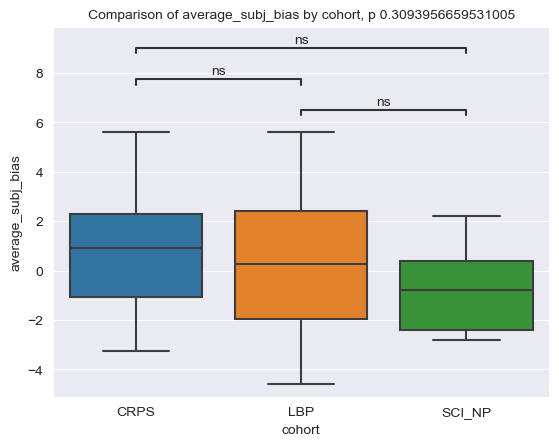

In [10]:
# Create the boxplot
plt.figure()
fig, ax = plt.subplots()
ax = sns.boxplot(x=col, y=col_target, data=data_tmp, order=unique_values)
ax.set_xticklabels(unique_values)
ax.set_xlabel(col)
ax.set_ylabel(col_target)
ax.set_title(f'Comparison of {col_target} by {col}, p {kruskal_results.pvalue}')
combs = combinations(unique_values, 2)

# create a set to store the non-repeated pairs of tuples
pairs = set()

# convert each combination to a tuple and add it to the set
for comb in combs:
    pairs.add(tuple(sorted(comb)))
# Add the significance to the plot using statannot
stat_result = statannot.add_stat_annotation(ax, data=data_tmp,x=col,y=col_target,box_pairs=tuple(pairs),
                                  test="Kruskal", text_format='star', loc='inside',
                                  verbose=0, comparisons_correction=None)
plt.savefig(RESULTS_DIR_MEM+cohort+"cohort_vs_TIP_{}.pdf".format(col_target))
plt.show()

In [11]:
data['cohort'].value_counts()

LBP       51
CRPS      19
SCI_NP    11
Name: cohort, dtype: int64